## Импорты


In [2]:
# from google.colab import drive
import pandas as pd

import numpy as np
from numpy import mean
from numpy import std
from numpy import ravel

import scipy
import joblib
import re
import glob
import sklearn
from math import sqrt
from decimal import Decimal


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_percentage_error

import xgboost as xgb
from xgboost import XGBRegressor

from geopy.exc import GeocoderTimedOut
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

from tqdm import tqdm

# !pip install CurrencyConverter
from currency_converter import CurrencyConverter


In [3]:
# Визуализация
import seaborn as sns

import matplotlib.pyplot as plt

from mlxtend.plotting import plot_decision_regions

from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.dpi'] = 150
plt.style.use('seaborn-deep')
pd.set_option('display.max_columns', None)
# scipy.test()

# Препроцессинг


## Выгрузка данных и объединение


In [ ]:
# сохраненяем все имена файлов в папку в один масив
files = [item for item in glob.glob(r'/content/drive/MyDrive/parsing_vtorichka/Cian data/*{}'.format('.xlsx'))]
# files

In [ ]:
# объеденяем все файлы в один файл 
combined = pd.DataFrame()
for i in files:
  file = pd.read_excel(i)
  combined = pd.concat([combined, file])

KeyboardInterrupt: ignored

In [ ]:
# сохраниние файла в csv 
combined.to_csv('file_02.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/file_02.csv')
df

## Чистка данных (Работаем с NuN, фильтруем лишнюю информацию, разбиваем по колонкам)

In [ ]:
# Удаляем дубликаты по ID 
df = df.drop_duplicates(subset=['ID'], keep='first').reset_index(drop = True)

In [ ]:
# Удаляем не нужные столбцы
df = df.drop(['Unnamed: 0', 'ID', 'Телефоны', 'Описание', 'Есть телефон', 'Название ЖК', 'Серия дома', 'Ссылка на объявление'], axis = 1)

In [ ]:
# Заполняем нан в количество комнат, ремонт 
df['Количество комнат'] = df['Количество комнат'].fillna('Свободная планировка')
df['Ремонт'] = df['Ремонт'].fillna('Без ремонта')

In [ ]:
# Добавляем новый столбец, и заполняем типом квартиры из кол-во комнат, а там где нет кол-во, заполняем стандартом
df['Тип квартиры'] = [row.split(', ')[-1] if len(row) != 1 else 'Стандарт' for row in df['Количество комнат']]

In [ ]:
# Изменяем колонку кол-во комнат оставляя там только кол-во квартир, а там где нет ко-во ставим 0
df['Количество комнат'] = [int(row.split(', ')[0]) if len(row.split(', ')[0]) == 1 else 0 for row in df['Количество комнат']]

In [ ]:
# Обрабатываем колонку метро
df['Метро'] = [row.split(' (')[0] for row in df['Метро']]
df['Метро'] = [row.split('. ')[1] for row in df['Метро']]

In [ ]:
# Обрабатываем колонку с площадью, берём только общую площадь
df['Площадь кв, м2'] = [row.split('/')[0] for row in df['Площадь, м2']]
# df['Площадь жилая, м2'] = [row.split('/')[1] if len(row) > 6 else 0 for row in df['Площадь, м2']]
# df['Площадь кухни, м2'] = [row.split('/')[-1] if len(row) > 6 else 0 for row in df['Площадь, м2']]

In [ ]:
# Удаляем колонку со старой площадью
df = df.drop(['Площадь, м2'], axis = 1)
df = df.drop(['Площадь комнат, м2'], axis = 1)

In [ ]:
# Обрабатываем колонку "парковка"
df['Парковка'] = df['Парковка'].replace(to_replace ='открытая', value = 'бесплатная во дворе', regex = True)
df['Парковка'] = df['Парковка'].replace(to_replace ='наземная', value = 'платная во дворе', regex = True)
df['Парковка'] = df['Парковка'].fillna('бесплатная во дворе')

In [ ]:
# Обрабатываем колонку "балкон"
df['Балкон'] = df['Балкон'].fillna('Балкон (0), Лоджия (0)')
df['Лоджия'] = [row.split(' ')[-1] if (row.split(' ')[-2]) == 'Лоджия' else '(0)' for row in df['Балкон']]
df['Балкон'] = [row.split(' ')[1] if row.split(' ')[0] == 'Балкон' else '(0)' for row in df['Балкон']]

In [ ]:
# Корректируем значения, избавляясь от скобок и переделывая из str в int
df['Лоджия'] = [row.split('(')[1] for row in df['Лоджия']]
df['Лоджия'] = [int(row.split(')')[0]) for row in df['Лоджия']]
df['Балкон'] = [row.split('(')[1] for row in df['Балкон']]
df['Балкон'] = [int(row.split(')')[0]) for row in df['Балкон']]

In [ ]:
# Все пропущенные окна закидываем в категорию "во двор"
# Есть вариант раскидать по всем колонкам
df['Окна'] = df['Окна'].fillna('Во двор')

In [ ]:
# Разбиваем колонку дом
df['Тип дома'] = [row.split(', ')[-1] if len(row.split(', ')[-1]) > 6 else 'Неизвестно' for row in df['Дом']]
df['Этажность дома'] = [int(row.split('/')[1].split(',')[0]) for row in df['Дом']]
df['Этаж квартиры'] = [int(row.split('/')[0]) for row in df['Дом']]
df = df.drop(['Дом'], axis = 1)

In [ ]:
# Избавляемся от NaN, если меньше 5 этажей - нет лифта, в остальном по одному каждого лифта
df['Лифт'] = [row if row == row else
              ['Пасс (1), Груз (1)' if df['Этажность дома'].iloc[i]>5 else 'Пасс (0), Груз (0)'][0]
              for i, row in enumerate(df['Лифт'])]

In [ ]:
# Разбиваем колонку с лифтами на две раздельные 
df['Лифт пасс'] = [row.split(' ')[1] if (row.split(' ')[0]) == 'Пасс' else '(0)' for row in df['Лифт']]
df['Лифт груз'] = [row.split(' ')[-1] if (row.split(' ')[-2]) == 'Груз' else '(0)' for row in df['Лифт']]

In [ ]:
# Убираем скобки
df['Лифт пасс'] = [row.split('(')[1] for row in df['Лифт пасс']]
df['Лифт пасс'] = [int(row.split(')')[0]) for row in df['Лифт пасс']]
df['Лифт груз'] = [row.split('(')[1] for row in df['Лифт груз']]
df['Лифт груз'] = [int(row.split(')')[0]) for row in df['Лифт груз']]
df = df.drop(['Лифт'], axis = 1)

In [ ]:
# Аналогичные операции с колонкой "Санузел"
df['Санузел'] = df['Санузел'].fillna('Совмещенный (1)')
df['Санузел совмещенный'] = [row.split(' ')[1] if (row.split(' ')[0]) == 'Совмещенный' else '(0)' for row in df['Санузел']]
df['Санузел раздельный'] = [row.split(' ')[-1] if (row.split(' ')[-2]) == 'Раздельный' else '(0)' for row in df['Санузел']]
df['Санузел совмещенный'] = [row.split('(')[1] for row in df['Санузел совмещенный']]
df['Санузел совмещенный'] = [int(row.split(')')[0]) for row in df['Санузел совмещенный']]
df['Санузел раздельный'] = [row.split('(')[1] for row in df['Санузел раздельный']]
df['Санузел раздельный'] = [int(row.split(')')[0]) for row in df['Санузел раздельный']]
df = df.drop(['Санузел'], axis = 1)

In [ ]:
# Заполняем NaNы
df['Мусоропровод'] = df['Мусоропровод'].fillna('Нет')

In [ ]:
# Заполняем пустые значения средними
df['Высота потолков, м'] = df['Высота потолков, м'].fillna(round(df['Высота потолков, м'].mean(), 2))

In [ ]:
# Проверяем, что всё сделали правильно:)
# df[df['Тип квартиры'].isin(['Стандарт'])]
# df[df['Ремонт'].isna()].tail(50)
# print(len(df['Высота потолков, м'].unique()))
# print(df['Высота потолков, м'].unique())
# print(df['Высота потолков, м'].value_counts())
# print(round(df['Высота потолков, м'].mean(), 2))

### Currency Converter


In [ ]:
# Переводим цену по актуальному курсу, если указана не в рублях
c = CurrencyConverter()
def sale(text):
  if text.split(' ')[1] == 'руб.,':
    result = int(text.split(' ')[0])
  elif text.split(' ')[1] == '$,':
    result = int(c.convert((text.split(' ')[0]), 'USD', 'RUB'))
  elif text.split(' ')[1] == '€,':
    result = int(c.convert((text.split(' ')[0]), 'EUR', 'RUB')) 
  return result

In [ ]:
text = df['Цена']
text = text.apply(sale)
df['Цена'] = text

## Москва


In [ ]:
# Создаём датасет только с Москвой и МО
df_msk = df[df['Адрес'].str.contains("Москва")].reset_index(drop = True)

In [7]:
# Сохраняем датасет
df_msk.to_csv('msk.csv')

In [8]:
# Открываем датасет:)
df_msk = pd.read_csv('/content/drive/MyDrive/мусор/msk.csv')
df_msk = df_msk.drop('Unnamed: 0', axis = 1)

In [9]:
# Удаляем выбросы 
df_msk = df_msk[df_msk['Площадь кв, м2'] < 750].reset_index(drop = True)
df_msk = df_msk[df_msk['Цена'] < 1000000000].reset_index(drop = True)

In [10]:
# Удаляем концы адреса по типу "ш. Варшавское (4 км до МКАД)"
df_msk['Адрес'] = [row.split('ш. ')[0] for row in df_msk['Адрес']]
df_msk = df_msk[df_msk['Адрес'] != 'Москва, Жилой Поколение кв-л'].reset_index(drop = True)

In [11]:
# Как можем применяем regexp
def clean(text2):
    text2 = re.sub(r'городской округ', ' ', text2)
    text2 = re.sub(r' рп. ', ' ', text2)
    text2 = re.sub(r' рп ', ' ', text2)
    text2 = re.sub(r'улица 1-я', '1-я улица ', text2)
    text2 = re.sub(r'улица 2-я', '2-я улица ', text2)
    text2 = re.sub(r'улица 3-я', '3-я улица ', text2)
    text2 = re.sub(r'улица 4-я', '4-я улица ', text2)
    text2 = re.sub(r'улица 5-я', '5-я улица ', text2)
    text2 = re.sub(r'улица 6-я', '6-я улица ', text2)
    text2 = re.sub(r'улица 7-я', '7-я улица ', text2)
    text2 = re.sub(r'улица 8-я', '8-я улица ', text2)
    text2 = re.sub(r'улица 9-я', '9-я улица ', text2)
    text2 = re.sub(r'улица 10-я', '10-я улица ', text2)
    text2 = re.sub(r'улица 11-я', '11-я улица ', text2)
    text2 = re.sub(r'улица 12-я', '12-я улица ', text2)
    text2 = re.sub(r'улица 13-я', '13-я улица ', text2)
    text2 = re.sub(r'улица 14-я', '14-я улица ', text2)
    text2 = re.sub(r'улица 15-я', '15-я улица ', text2)
    text2 = re.sub(r'улица 16-я', '16-я улица ', text2)
    text2 = re.sub(r'улица 17-я', '17-я улица ', text2)
    text2 = re.sub(r'улица 18-я', '18-я улица ', text2)
    text2 = re.sub(r'улица 19-я', '19-я улица ', text2)
    text2 = re.sub(r'улица 20-я', '20-я улица ', text2)
    text2 = re.sub(r'Дежнева', 'Дежнёва', text2)
    text2 = re.sub(r'Щелков', 'Щёлков', text2)
    text2 = re.sub(r'Черемуш', 'Черёмуш', text2)
    text2 = re.sub(r'Хороше', 'Хорошё', text2)
    text2 = re.sub(r'мкр', ' ', text2)
    text2 = re.sub(r'пос', ' ', text2)
    text2 = re.sub(r'([0-999])[кК]+(?=[0-999])', r'\1 к', text2) # работает!
    text2 = re.sub(r'([0-999])[сС]+(?=[0-999])', r'\1 с', text2)  # работает!
    text2 = re.sub(r'([0-999])[Ак]+(?=[0-999])', r'\1А к', text2)  # работает!
    text2 = re.sub(r'([0-999])[Ас]+(?=[0-999])', r'\1А с', text2)  # работает!
    text2 = re.sub(r'([0-999])[Бк]+(?=[0-999])', r'\1Б к', text2)  # работает!
    text2 = re.sub(r'([0-999])[Вк]+(?=[0-999])', r'\1В к', text2)  # работает!
    text2 = re.sub(r'([0-999])[Гк]+(?=[0-999])', r'\1Г к', text2)  # работает!
    text2 = re.sub(r'([0-999])[Бс]+(?=[0-999])', r'\1Б с', text2)  # работает!
    text2 = re.sub(r'([0-999])[Вс]+(?=[0-999])', r'\1В ', text2)  # работает!
    text2 = re.sub(r'([0-999])[Гс]+(?=[0-999])', r'\1Г с', text2)  # работает!
    text2 = re.sub(r'([0-999])[Дк]+(?=[0-999])', r'\1В к', text2)  # работает!
    text2 = re.sub(r'([0-999])[Дс]+(?=[0-999])', r'\1Д с', text2)  # работает!
    text2 = re.sub(r'([0-999])[АК]+(?=[0-999])', r'\1А К', text2)  # работает!
    text2 = re.sub(r'([0-999])[АС]+(?=[0-999])', r'\1А С', text2)  # работает!
    text2 = re.sub(r'([0-999])[БК]+(?=[0-999])', r'\1Б К', text2)  # работает!
    text2 = re.sub(r'([0-999])[ВК]+(?=[0-999])', r'\1В К', text2)  # работает!
    text2 = re.sub(r'([0-999])[ГК]+(?=[0-999])', r'\1Г К', text2)  # работает!
    text2 = re.sub(r'([0-999])[БС]+(?=[0-999])', r'\1Б С', text2)  # работает!
    text2 = re.sub(r'([0-999])[ВС]+(?=[0-999])', r'\1В С', text2)  # работает!
    text2 = re.sub(r'([0-999])[ГС]+(?=[0-999])', r'\1Г С', text2)  # работает!
    text2 = re.sub(r'([0-999])[ДК]+(?=[0-999])', r'\1В К', text2)  # работает!
    text2 = re.sub(r'([0-999])[ДС]+(?=[0-999])', r'\1Д С', text2)  # работает!
    text2 = re.sub(r'\\s*(ул|пер(?:.+?к)?|бул(?:.+?р)?|тупик|набережная|аллея|пло щ(.+?ь)?|проезд|кольцо)[.,]', r'\1 ', text2)
    return text2

In [12]:
# Применяем чистку к каждому нашему адресу
text2 = df_msk['Адрес']
text2 = text2.apply(clean)
df_msk['Адрес'] = text2

In [13]:
# Избавляемся от всех "ЖК", т.к. на карте не находятся
def delete_zhk(text3):
  res = ''
  for i in text3.split(', '):
    if 'ЖК' in i:
      a = text3.split(', ').index(i)
      b = text3.split(', ')[:a] + text3.split(', ')[a+1:]
      return ' '.join(b)
    else:
      res = text3
  return res

In [14]:
text3 = df_msk['Адрес']
text3 = text3.apply(delete_zhk)
df_msk['Адрес'] = text3

#### Адреса в координаты

In [14]:
# Преобразуем все адреса в координаты!
empty_list = []
def do_geocode(address, attempt=1, max_attempts=5):
  try:
    empty_list.append(Nominatim(user_agent="my_request").geocode(address, timeout=None)[-1])
  except GeocoderTimedOut:
    if attempt <= max_attempts:
      return do_geocode(address, attempt=attempt+1)
    raise

In [ ]:
for row in tqdm(df_msk['Адрес']):
  try:
    do_geocode(row)
  except:
    empty_list.append('None')

  0%|          | 42/47583 [00:21<6:34:59,  2.01it/s]

### Графики МСК

In [25]:
# создаем графики зависимости категориальных данных к цене, то есть мы хотим понимать сильно ли влияет категория на стоимость дома
def plot_mean_price(column):
    plt.figure(figsize=(8, 4)) # определение размера графиков
    n_bars = np.arange(len(df_msk[column].unique())) # массив с кол-во уникальных значений в каждой катег колонке.
    
    # создание дф по каждой колонке групируя категории по средней цене
    grouped = pd.DataFrame(df_msk.groupby([column])['Цена'].mean().round())
    
    plt.title(column) #  заголовок
    plt.bar(n_bars, grouped['Цена']) # создание графика
    plt.xticks(n_bars, grouped.index); # подписываем колонки
    plt.show() # чтобы не накладывался на один график

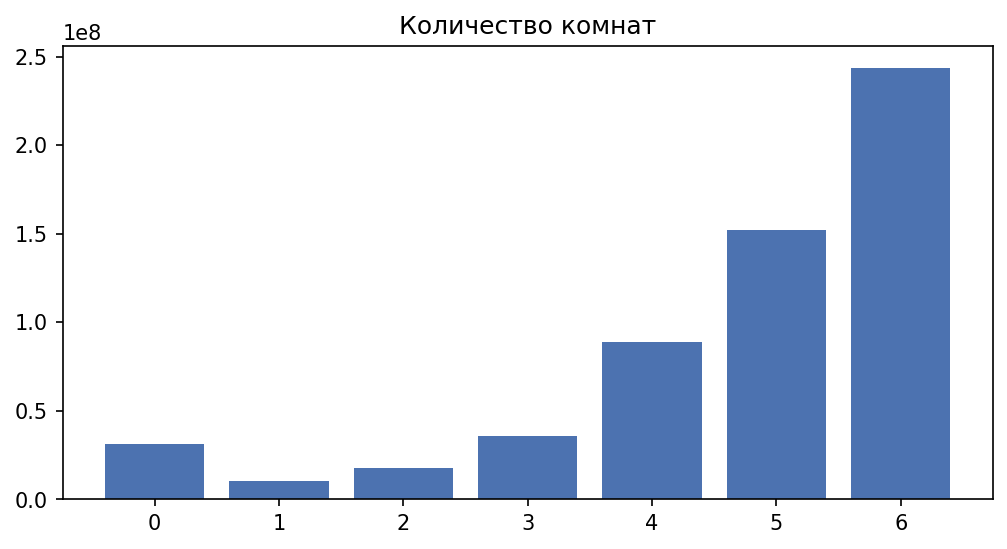

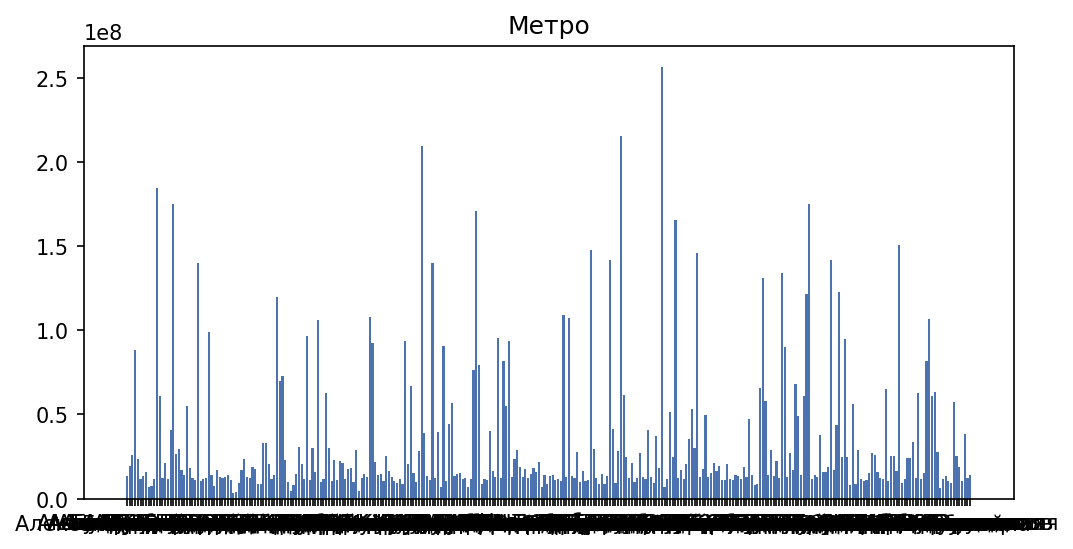

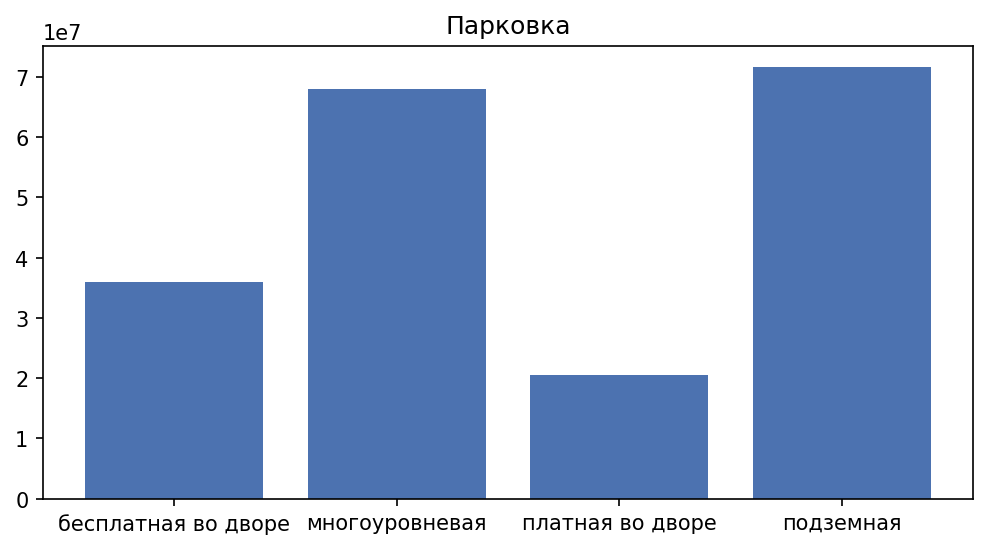

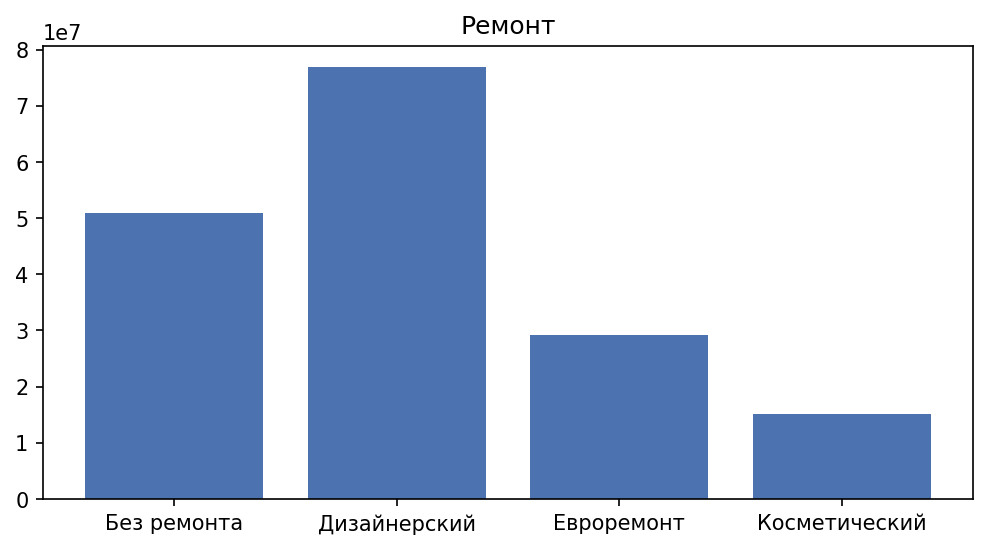

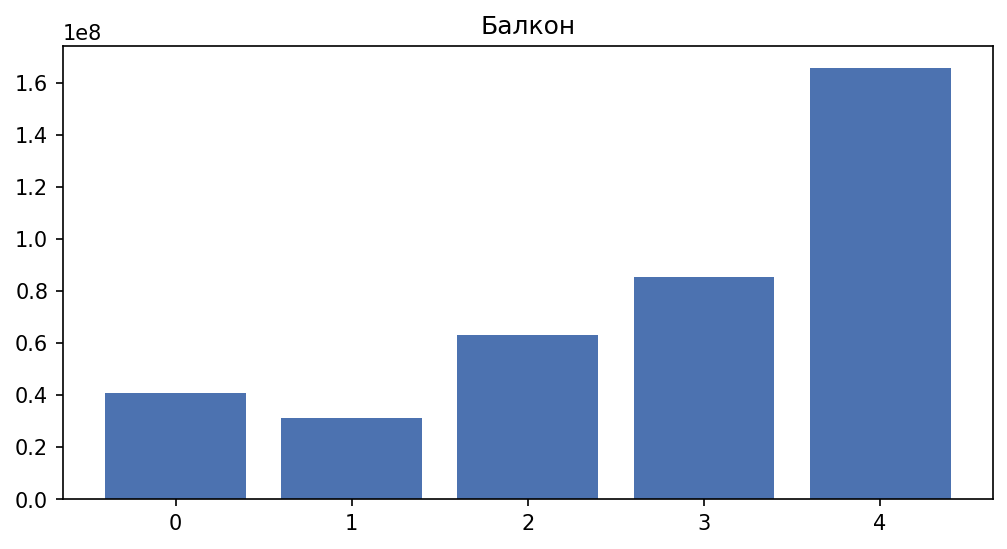

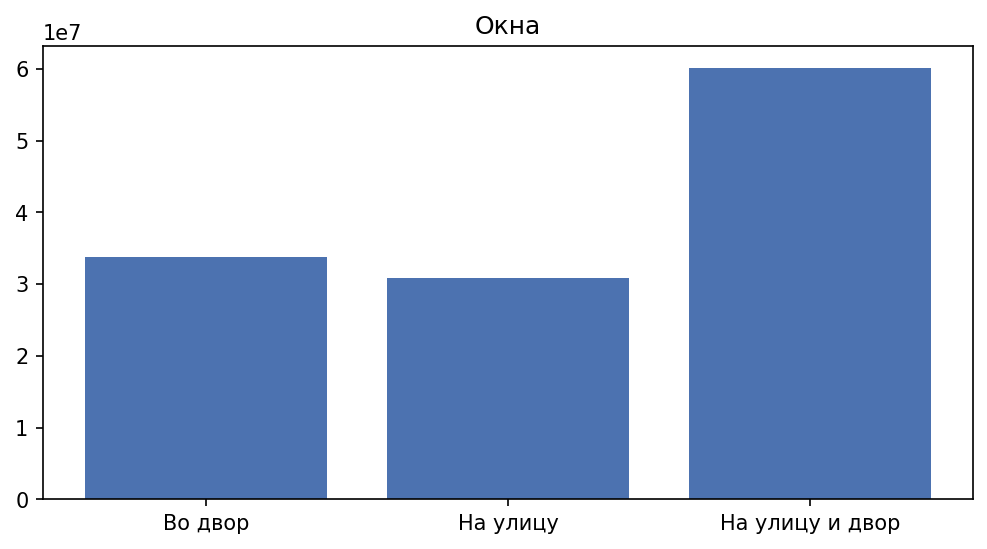

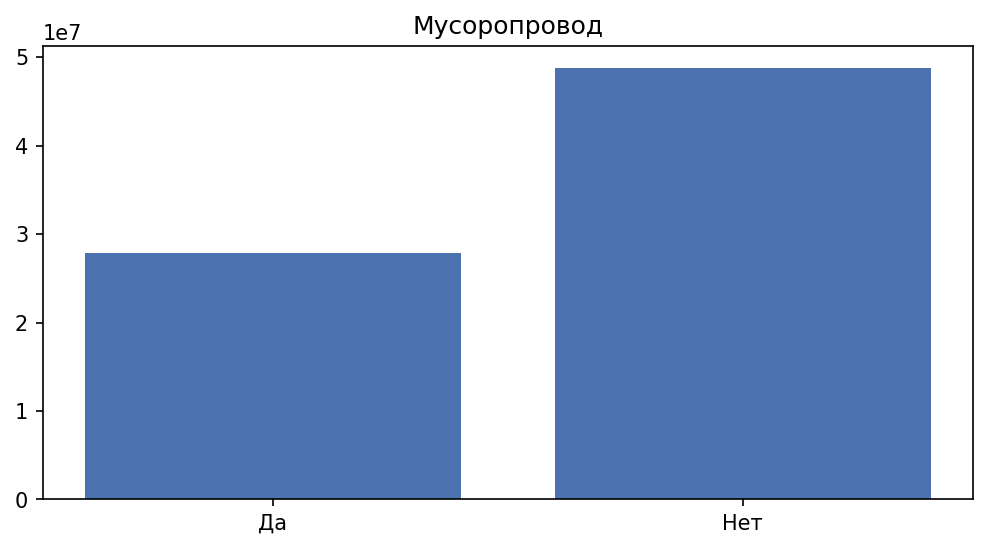

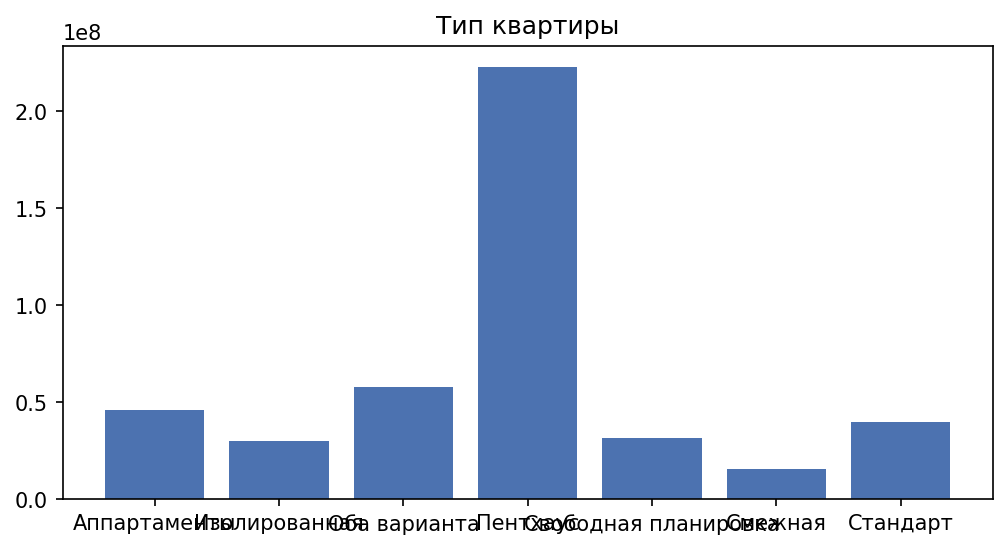

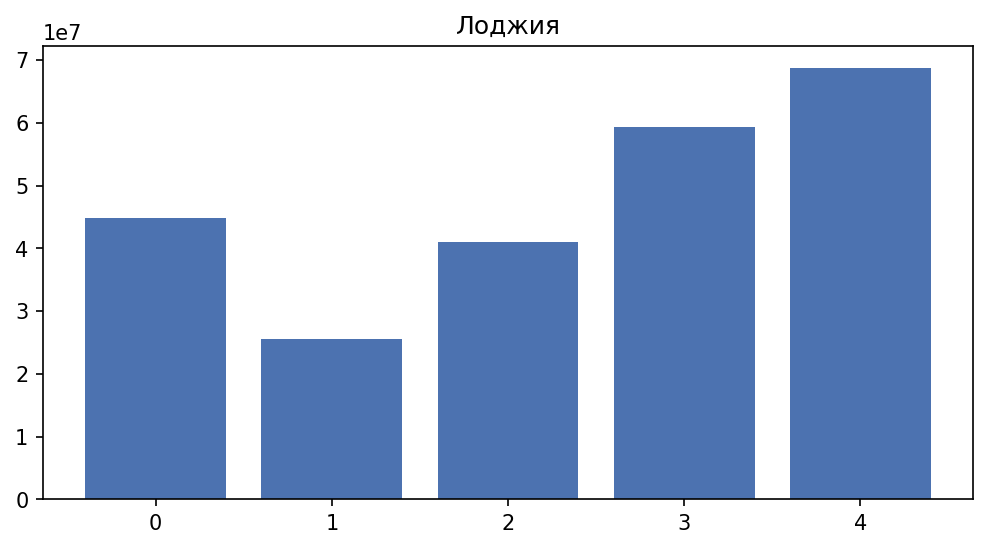

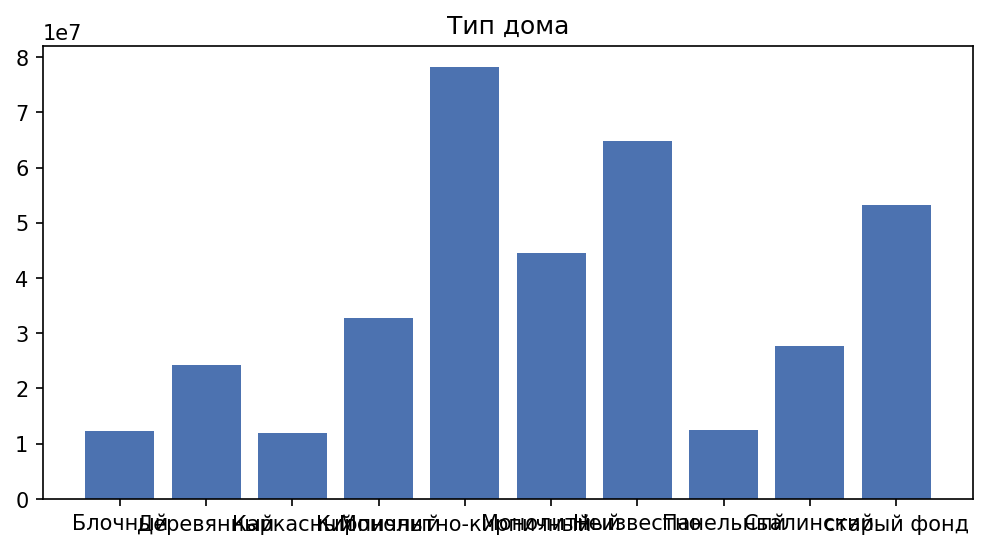

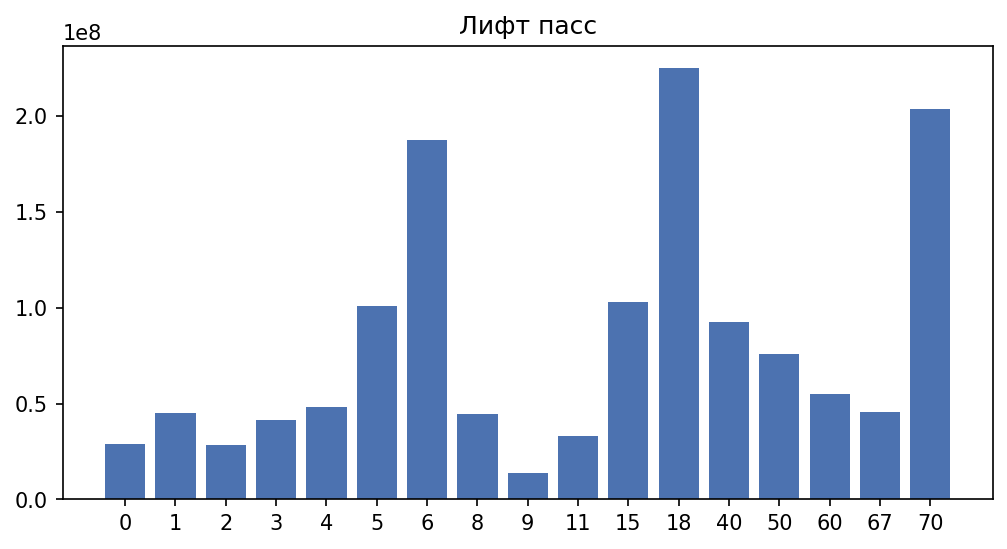

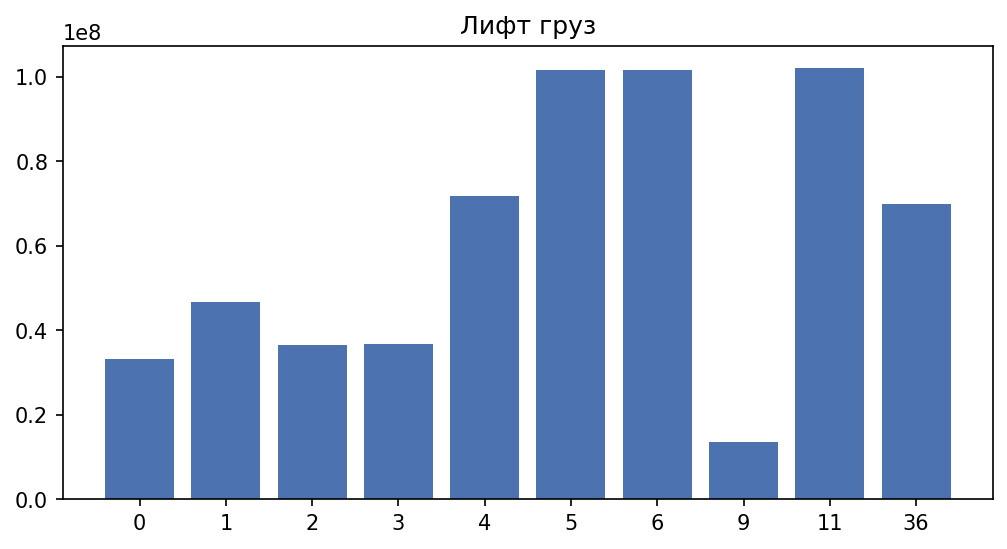

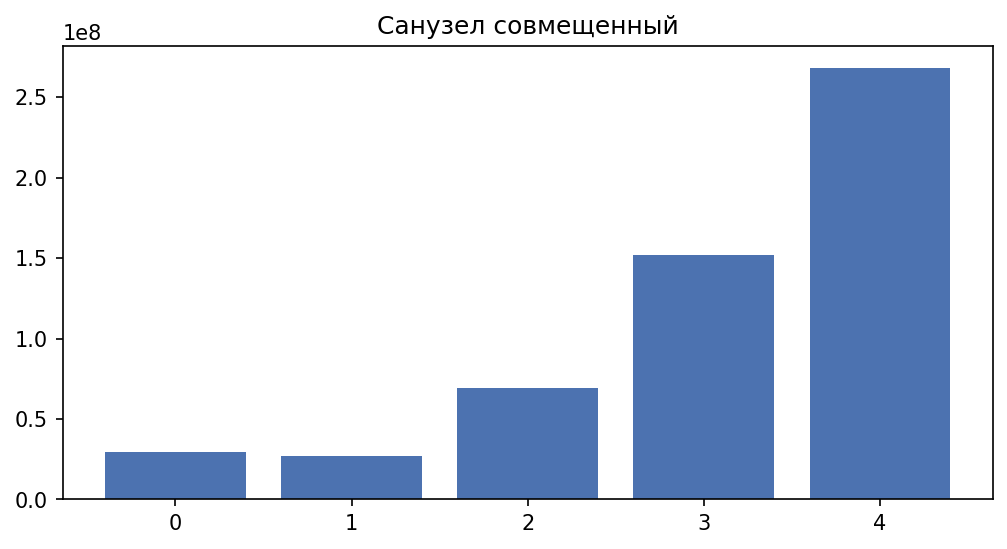

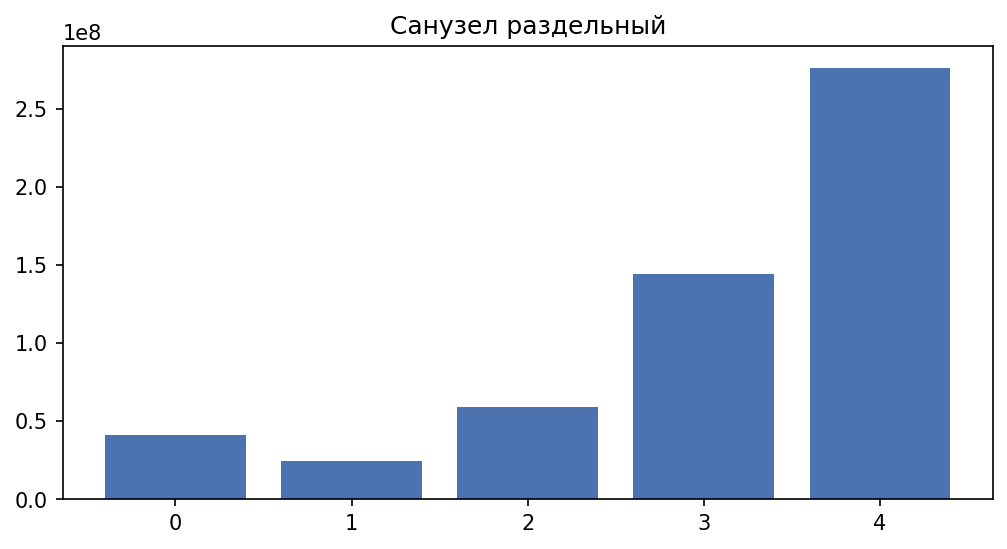

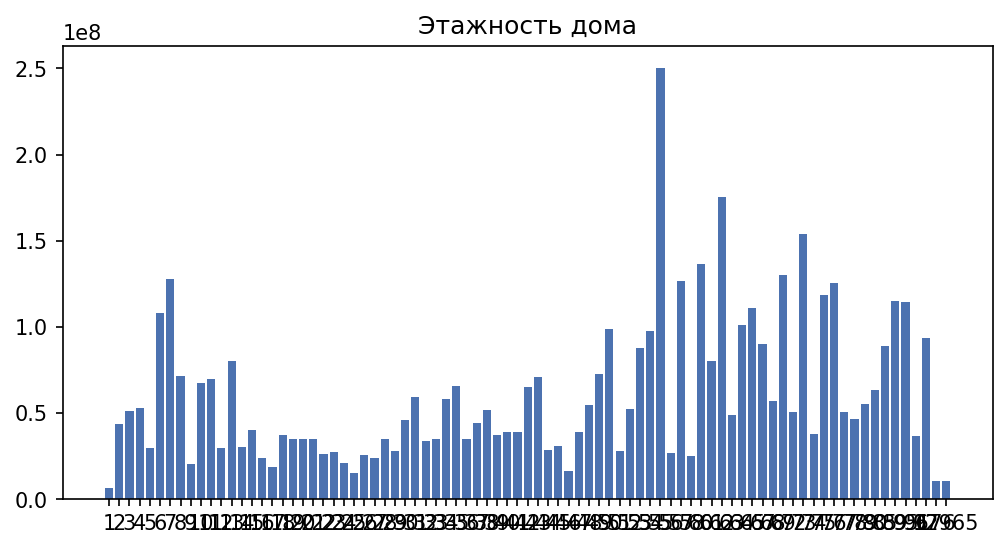

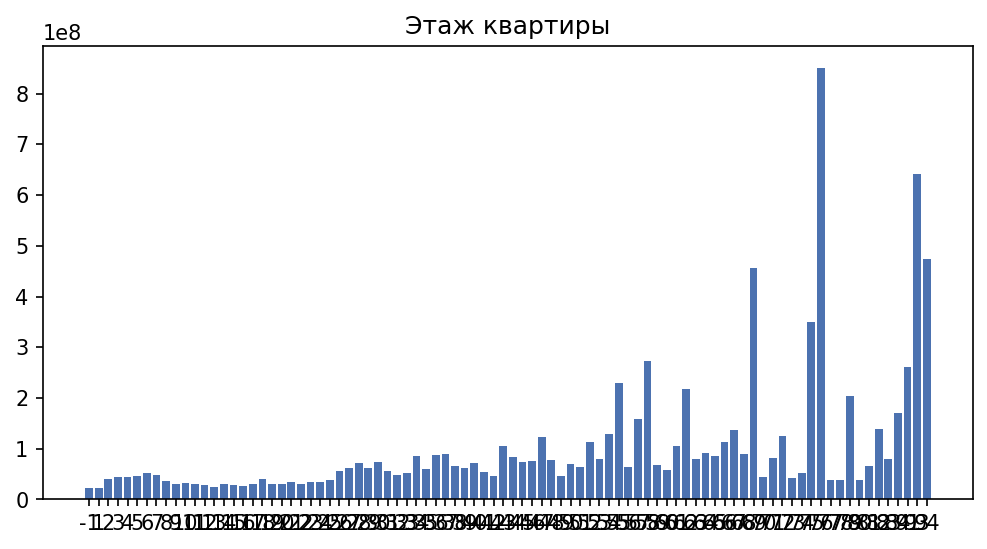

In [22]:
categorical = ['Количество комнат', 'Метро', 'Парковка', 'Ремонт', 'Балкон',
       'Окна', 'Мусоропровод', 'Тип квартиры',
       'Лоджия', 'Тип дома', 'Лифт пасс', 'Лифт груз', 'Санузел совмещенный',
       'Санузел раздельный', 'Этажность дома', 'Этаж квартиры']
for col in categorical:
    plot_mean_price(col) #вызываем функцию дя построение графиков

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


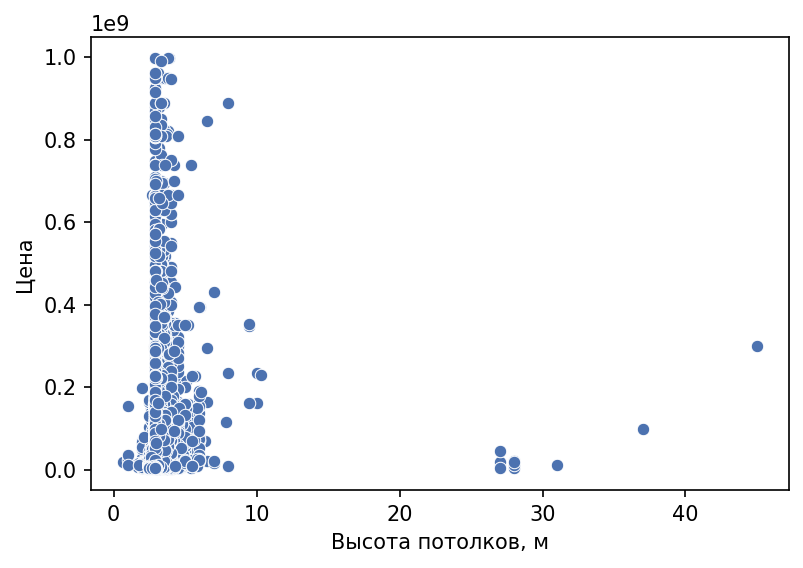

In [26]:
# График Высота потолков, м \ цена
sns.scatterplot(df_msk['Высота потолков, м'], df_msk['Цена']);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


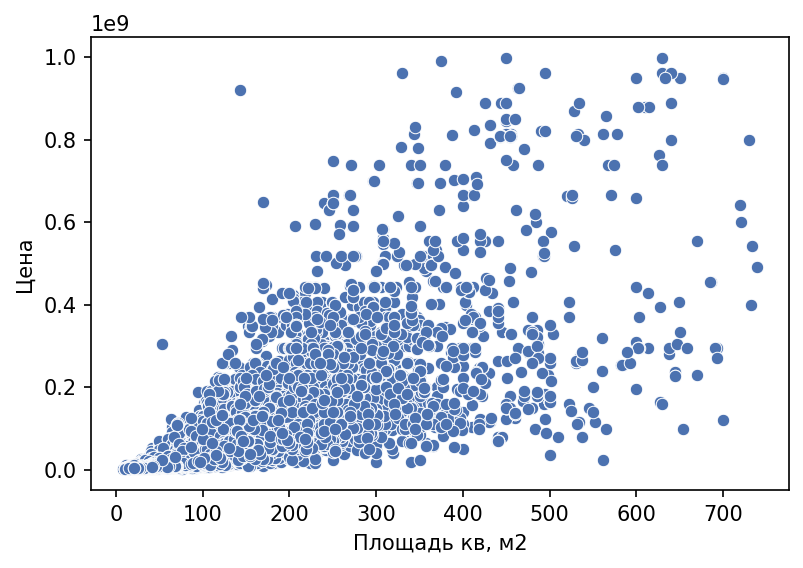

In [14]:
# График Суммарная площадь \ цена
sns.scatterplot(df_msk['Площадь кв, м2'], df_msk['Цена']);

## Москва с координатами


In [54]:
msk_cor = pd.read_csv('/content/drive/MyDrive/msk_cor.csv')
del msk_cor['Unnamed: 0']
del msk_cor['Unnamed: 0.1']
del msk_cor['Тип']
del msk_cor['Адрес']

In [55]:
# Подчищаем выбросы : этажность, потолки, лифты
msk_cor = msk_cor[msk_cor['Этажность дома'] < 200].reset_index(drop = True)
msk_cor = msk_cor[msk_cor['Высота потолков, м'] < 10].reset_index(drop = True)
msk_cor = msk_cor[msk_cor['Высота потолков, м'] > 2].reset_index(drop = True)
msk_cor = msk_cor[msk_cor['Лифт пасс'] < 6].reset_index(drop = True)
msk_cor = msk_cor[msk_cor['Лифт груз'] < 6].reset_index(drop = True)

In [56]:
# Выкидываем колонки с NaN 
msk_cor = msk_cor.dropna().reset_index(drop = True)

In [57]:
# Удаляем скобки у координат
msk_cor['Адрес координаты'] = [row.split('(')[1] for row in msk_cor['Адрес координаты']]
msk_cor['Адрес координаты'] = [row.split(')')[0] for row in msk_cor['Адрес координаты']]

In [58]:
# Раскидываем Координаты на две разные колонки
msk_cor['Широта'] = [float(row.split(',')[0]) for row in msk_cor['Адрес координаты']]
msk_cor['Долгота'] = [float(row.split(',')[1]) for row in msk_cor['Адрес координаты']]
del msk_cor['Адрес координаты']

In [59]:
# Просчитываем расстояние от центра до каждого Адреса по координатам
KREMLIN_LAT = [55.75141] * len(msk_cor['Широта'])
KREMLIN_LONG = [37.61896] * len(msk_cor['Широта'])
msk_cor['Расстояние'] = [round(geodesic((msk_cor['Широта'][row],
                                       msk_cor['Долгота'][row]), (KREMLIN_LAT[row], KREMLIN_LONG[row])).km, 2)
                       for row in range(len(msk_cor['Широта']))]

In [60]:
# Удаляем выбросы \ удалённые квартиры
msk_cor = msk_cor[msk_cor['Расстояние'] < 25].reset_index(drop = True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


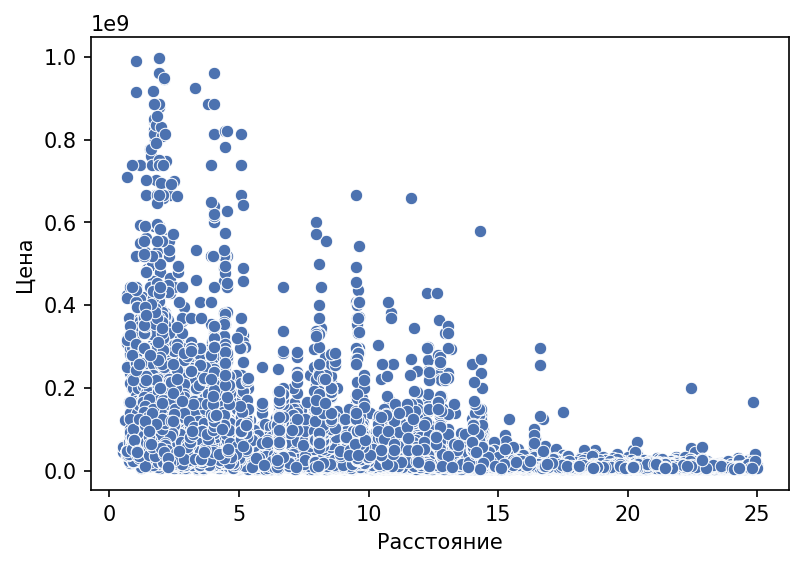

In [61]:
# График Расстояние \ Цена
sns.scatterplot(msk_cor['Расстояние'], msk_cor['Цена']);

In [62]:
# Создаём новый параметр, зависящий от расстояния
res = ''
def circle(text4):
  if text4 < 2.5:
    res = 'Садовое кольцо'
  elif 2.5 < text4 < 5:
    res = 'ТТК'
  elif 5 < text4 < 17:
    res = 'МКАД'
  else:
    res = 'ЗАМКАДЫШИ'
  return res

In [63]:
text4 = msk_cor['Расстояние']
text4 = text4.apply(circle)
msk_cor['Окружность'] = text4

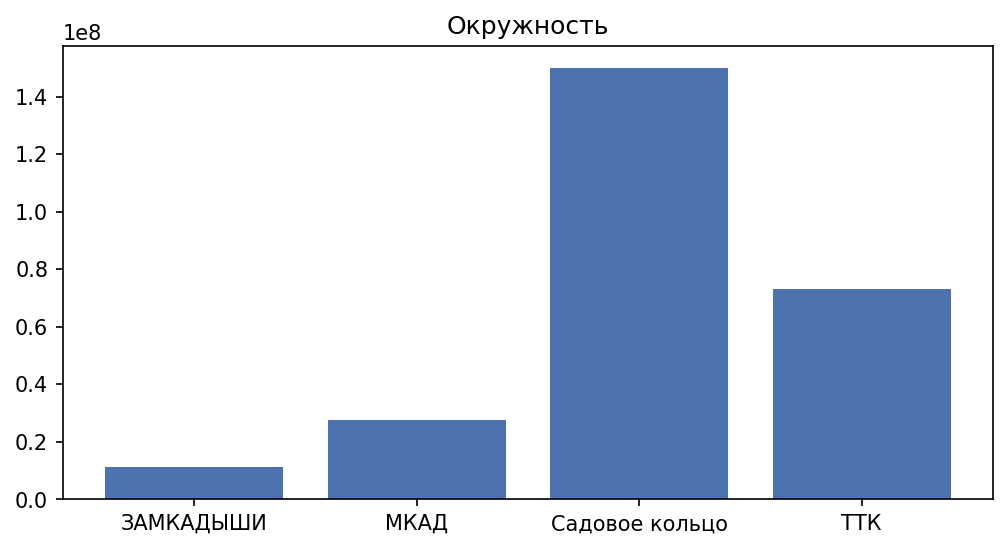

In [64]:
# Соотношение окружность \ средняя цена
plt.figure(figsize=(8, 4))

n_bars = np.arange(len(msk_cor['Окружность'].unique())) 

grouped = pd.DataFrame(msk_cor.groupby(['Окружность'])['Цена'].mean().round())

plt.title('Окружность')
plt.bar(n_bars, grouped['Цена'])
plt.xticks(n_bars, grouped.index); 

In [65]:
# Вместо отдельного txt файла и импорта:)

VAO = [
    'Авиамоторная',
    'Андроновка',
    'Белокаменная',
    'Бульвар Рокоссовского',
    'Измайлово',
    'Измайловская',
    'Локомотив',
    'Лухмановская',
    'Новогиреево',
    'Новокосино',
    'Партизанская',
    'Первомайская',
    'Перово',
    'Преображенская площадь',
    'Семеновская',
    'Соколиная Гора',
    'Сокольники',
    'Улица Дмитриевского',
    'Черкизовская',
    'Шоссе Энтузиастов',
    'Щелковская',
    'Электрозаводская',
    'Стромынка',
]

ZAO = [
    'Багратионовская',
    'Боровское шоссе',
    'Киевская',
    'Кропоткинская',
    'Крылатское',
    'Кунцевская',
    'Кутузовская',
    'Ломоносовский проспект',
    'Минская',
    'Мичуринский проспект',
    'Молодежная',
    'Новопеределкино',
    'Озёрная',
    'Озерная',
    'Парк Победы',
    'Пионерская',
    'Проспект Вернадского',
    'Рабочий Посёлок',
    'Рабочий поселок',
    'Рабочий посёлок',
    'Рабочий Поселок',
    'Раменки',
    'Сетунь',
    'Славянский бульвар',
    'Славянский бульвар',
    'Солнцево',
    'Студенческая',
    'Тропарёво',
    'Тропарево',
    'Филевский парк',
    'Фили',
    'Фили',
    'Юго-Западная',
    'Аминьевское шоссе',
    'Давыдково',
    'Дорогомиловская',
    'Кунцевская',
    'Проспект Вернадского',
    'Улица Новаторов',
]

NAO = [
    'Говорово',
    'Коммунарка',
    'Ольховая',
    'Остафьево',
    'Прокшино',
    'Рассказовка',
    'Румянцево',
    'Саларьево',
    'Филатов Луг',
    'Щербинка',
]

SAO = [
    'Аэропорт',
    'Балтийская',
    'Беговая',
    'Беломорская',
    'Бескудниково',
    'Верхние Лихоборы',
    'Водный стадион',
    'Войковская',
    'Гражданская',
    'Дегунино',
    'Динамо',
    'Дмитровская',
    'Зорге',
    'Коптево',
    'Красный Балтиец',
    'Лихоборы',
    'Марк',
    'Окружная',
    'Панфиловская',
    'Петровский парк',
    'Петровский Парк',
    'Петровско-Разумовская',
    'Покровское-Стрешнево',
    'Полежаевская',
    'Речной вокзал',
    'Савеловская',
    'Сокол',
    'Стрешнево',
    'Тимирязевская',
    'Ховрино',
    'Хорошёво',
    'Хорошево',
    'Хорошёвская',
    'Хорошевская',
    'ЦСКА',
    'Беломорская улица',
    'Петровский парк',
    'Петровско-Разумовская',
]

SVAO = [
    'Алексеевская',
    'Алтуфьево',
    'Бабушкинская',
    'Бибирево',
    'Ботанический сад',
    'Бутырская',
    'ВДНХ',
    'Владыкино',
    'Выставочный центр',
    'Лианозово',
    'Марьина роща',
    'Медведково',
    'Окружная',
    'Отрадное',
    'Ростокино',
    'Савеловская',
    'Свиблово',
    'Телецентр',
    'Улица Академика Королёва',
    'Улица академика королева',
    'Улица Академика королева',
    'Улица академика Королева',
    'Улица академика королёва',
    'Улица Академика королёва',
    'Улица академика Королёва',
    'Улица Милашенкова',
    'Улица Сергея Эйзенштейна',
    'Фонвизинская',
    'Бутырская',
    'Фонвизинская',
    'Шереметьевская',
]

SZAO = [
    'Волоколамская',
    'Митино',
    'Мнёвники',
    'Народное Ополчение',
    'Народное ополчение',
    'Октябрьское поле',
    'Пенягино',
    'Планерная',
    'Пятницкое шоссе',
    'Спартак',
    'Строгино',
    'Сходненская',
    'Трикотажная',
    'Тушинская',
    'Щукинская',
    'Нижние Мневники',
    'Терехово',
    'Улица Народного ополчения',
]

CAO = [
    'Александровский сад',
    'Арбатская',
    'Баррикадная',
    'Бауманская',
    'Беговая',
    'Белорусская',
    'Библиотека имени Ленина',
    'Боровицкая',
    'Воробьевы горы',
    'Выставочная',
    'Деловой центр',
    'Добрынинская',
    'Достоевская',
    'Каланчёвская',
    'Китай-город',
    'Комсомольская',
    'Краснопресненская',
    'Красносельская',
    'Красные ворота',
    'Крестьянская застава',
    'Кузнецкий мост',
    'Курская',
    'Лубянка',
    'Лужники',
    'Марксистская',
    'Маяковская',
    'Международная',
    'Менделеевская',
    'Новокузнецкая',
    'Новослободская',
    'Октябрьская',
    'Охотный ряд',
    'Павелецкая',
    'Парк Культуры',
    'Площадь Ильича',
    'Площадь Революции',
    'Полянка',
    'Пролетарская',
    'Проспект Мира',
    'Пушкинская',
    'Рижская',
    'Римская',
    'Серпуховская',
    'Смоленская',
    'Смоленская',
    'Спортивная',
    'Сретенский бульвар',
    'Сухаревская',
    'Таганская',
    'Тверская',
    'Театральная',
    'Тестовская',
    'Третьяковская',
    'Трубная',
    'Тургеневская',
    'Улицаа 1905 года',
    'Фрунзенская',
    'Цветной бульвар',
    'Чеховская',
    'Чистые пруды',
    'Чкаловская',
    'Шелепиха',
    'Электрозаводская',
    'Волхонка',
    'Плющиха',
    'Ржевская',
    'Рубцовская',
]

UVAO = [
    'Авиамоторная',
    'Братиславская',
    'Волгоградский проспект',
    'Волжская',
    'Выхино',
    'Депо',
    'Дубровка',
    'Жулебино',
    'Калитники',
    'Кожуховская',
    'Косино',
    'Котельники',
    'Кубанская',
    'Кузьминки',
    'Курьяново',
    'Лермонтовский проспект',
    'Лефортово',
    'Люблино',
    'Марьино',
    'Москва-Товарная',
    'Некрасовка',
    'Нижегородская',
    'Новохохловская',
    'Новохохловская',
    'Окская',
    'Перерва',
    'Печатники',
    'Рязанский проспект',
    'Стахановская',
    'Текстильщики',
    'Текстильщики',
    'Угрешская',
    'Юго-Восточная',
    'Печатники',
    'Текстильщики',
]

UZAO = [
    'Академическая',
    'Беляево',
    'Битцевский парк',
    'Бульвар адмирала Ушакова',
    'Бульвар Адмирала ушакова',
    'Бульвар адмирала ушакова',
    'Бульвар Дмитрия Донского',
    'Бунинская Аллея',
    'Бунинская аллея',
    'Бутово',
    'Калужская',
    'Каховская',
    'Коньково',
    'Нахимовский Проспект',
    'Нахимовский проспект',
    'Новоясеневская',
    'Новые Черёмушки',
    'Новые Черемушки',
    'Новые черёмушки',
    'Площадь Гагарина',
    'Профсоюзная',
    'Севастопольская',
    'Зюзино',
    'Теплый стан',
    'Теплый Стан',
    'Улица Горчакова',
    'Улица Скобелевская',
    'Улица Старокачаловская',
    'Университет',
    'Ясенево',
    'Воронцовская',
    'Каховская',
    'Севастопольский проспект',
]

UAO = [
    'Автозаводская',
    'Автозаводская',
    'Алма-Атинская',
    'Аннино',
    'Борисово',
    'Варшавская',
    'Верхние Котлы',
    'Домодедовская',
    'ЗИЛ',
    'Зябликово',
    'Кантемировская',
    'Каширская',
    'Коломенская',
    'Красногвардейская',
    'Красный Строитель',
    'Крымская',
    'Ленинский проспект',
    'Лесопарковая',
    'Москворечье',
    'Нагатинская',
    'Нагорная',
    'Орехово',
    'Покровское',
    'Пражская',
    'Технопарк',
    'Тульская',
    'Улица академика Янгеля',
    'Царицыно',
    'Царицыно',
    'Чертановская',
    'Шаболовская',
    'Шипиловская',
    'Южная',
    'Каширская',
    'Кленовый бульвар',
]
RAYONI = [
    'Аникеевка',
    'Баковка',
    'Битца',
    'Водники',
    'Долгопрудная',
    'Красногорская',
    'Лобня',
    'Мякинино',
    'мякинино',
    'Нахабино',
    'Немчиновка',
    'Новодачная',
    'Одинцово',
    'Опалиха',
    'Павшино',
    'Подольск',
    'Силикатная',
    'Сколково',
    'Хлебниково',
    'Шереметьевская',
]

In [66]:
# Создание доп. параметр "Административный округ" путём elifов (на работе так делать не будем)
def district(text5):
    res = ''
    if text5 in VAO:
        res = 'ВАО'
    elif text5 in ZAO:
        res = 'ЗАО'
    elif text5 in NAO:
        res = 'НАО'
    elif text5 in SAO:
        res = 'САО'
    elif text5 in SVAO:
        res = 'СВАО'
    elif text5 in SZAO:
        res = 'СЗАО'
    elif text5 in CAO:
        res = 'ЦАО'
    elif text5 in UVAO:
        res = 'ЮВАО'
    elif text5 in UAO:
        res = 'ЮАО'
    elif text5 in UZAO:
        res = 'ЮЗАО'
    elif text5 in RAYONI:
        res = 'Районы'
    return res

In [67]:
text5 = msk_cor['Метро']
text5 = text5.apply(district)
msk_cor['Округ'] = text5

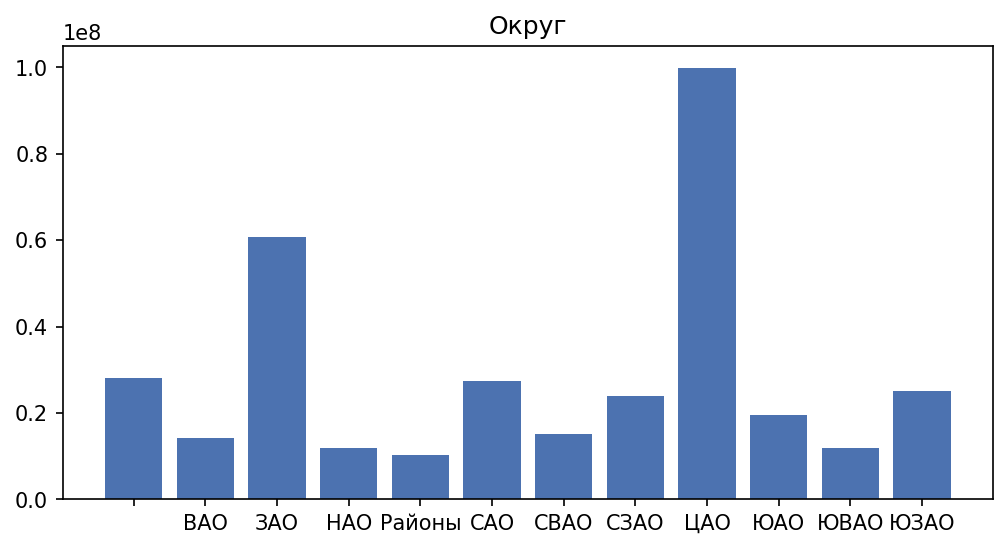

In [68]:
# Соотношение Округ \ средняя цена
plt.figure(figsize=(8, 4))

n_bars = np.arange(len(msk_cor['Округ'].unique())) 

grouped = pd.DataFrame(msk_cor.groupby(['Округ'])['Цена'].mean().round())

plt.title('Округ')
plt.bar(n_bars, grouped['Цена'])
plt.xticks(n_bars, grouped.index); 

In [69]:
# Исправляем косяк с разбиением комнатности квартр
msk_cor['Количество комнат'] = [7 if msk_cor['Тип квартиры'].iloc[i] == 'Свободная планировка' else row
                                for i, row in enumerate(msk_cor['Количество комнат'])]

In [70]:
# "Нормальный" подход к добавлению новой фичи по "метро"
my_dict =  {'Akadem' : ['Академическая'],
    'Aleks' : ['Алексеевская'],
    'Arbat' : [
        'Александровский сад',
        'Арбатская',
        'Боровицкая',
        'Смоленская',
    ],
    'Aeroport' : [
        'Аэропорт',
        'Динамо',
        'Красный Балтиец',
        'Петровский парк',
        'Сокол',
        'Петровский Парк',
    ],
    'Babushk' : ['Бабушкинская'],
    'Basmann' : [
        'Бауманская',
        'Курская',
        'Чистые пруды',
        'Чкаловская',
        'Электрозаводская',
        'Рубцовская',
    ],
    'Besskudnikovo' : [
        'Бескудниково',
        'Верхние Лихоборы',
        'Селигерская',
    ],
    'Bibirevo' : [
        'Алтуфьево',
        'Бибирево',
    ],
    'Birulevo_zapad' : ['Покровское'],
    'Bogorodsk' : [
        'Белокаменная',
        'Бульвар Рокоссовского',
    ],
    'Brateevo' : [
        'Алма-Атинская',
        'Борисово',
    ],
    'Butovo_sever' : [
        'Бульвар Дмитрия Донского',
        'Улица Старокачаловская',
    ],
    'Butovo_ug' : [
        'Бульвар адмирала Ушакова',
        'Бульвар Адмирала ушакова',
        'Бульвар адмирала ушакова',
        'Бунинская Аллея',
        'Бунинская аллея',
        'Бутово',
        'Улица Горчакова',
        'Улица Скобелевская',
    ],
    'Butirka' : [
        'Бутырская',
        'Улица Милашенкова',
        'Фонвизинская',
        'Бутырская',
        'Фонвизинская',
    ],
    'Vnukovo' : [
        'Рассказовка',
    ],
    'Voykovskaya' : [
        'Балтийская',
        'Войковская',
    ],
    'Zhulebino' : [
        'Выхино',
        'Жулебино',
        'Косино',
        'Котельники',
        'Лермонтовский проспект',
        'Юго-Восточная',
    ],
    'Gagarinskiy' : [
        'Площадь Гагарина',
        'Университет',
    ],
    'Golovinskiy' : [
        'Водный стадион'
    ],
    'Golyanovo' : [
        'Локомотив'
    ],
    'Danilovskiy' : [
        'Автозаводская',
        'ЗИЛ',
        'Технопарк',
        'Тульская',
    ],
    'Degunino_vostok' : [
        'Дегунино'
    ],
    'Dmitrovskiy' : [
        'Марк'
    ],
    'Donskoy' : [
        'Крымская',
        'Ленинский проспект',
        'Шаболовская',
    ],
    'Dorogomilovo' : [
        'Киевская',
        'Кутузовская',
        'Минская',
        'Парк Победы',
        'Студенческая',
        'Дорогомиловская',
    ],
    'Zamoskvorechie' : [
        'Добрынинская',
        'Новокузнецкая',
        'Павелецкая',
        'Серпуховская',
        'Третьяковская',
    ],
    'Zuzino' : [
        'Каховская',
        'Нахимовский Проспект',
        'Нахимовский проспект',
        'Севастопольская',
        'Зюзино',
        'Каховская',
        'Севастопольский проспект',
    ],
    'Zyablikovo' : [
        'Зябликово',
        'Красногвардейская',
        'Шипиловская',
    ],
    'Izmailovo' : [
        'Измайлово',
        'Измайловская',
        'Партизанская',
        'Первомайская',
        'Соколиная Гора',
    ],
    'Izmailovo_sever' : [
        'Щелковская'
    ],
    'Konkovo' : [
        'Беляево',
        'Коньково',
    ],
    'Koptevo' : [
        'Коптево',
        'Лихоборы',
    ],
    'Kosino_uhtomsk' : [
        'Лухмановская',
        'Улица Дмитриевского',
    ],

    'Krasnogorsk' : ['Мякинино', 'мякинино'],

    'Krasnoselsk' : [
        'Каланчёвская',
        'Комсомольская',
        'Красносельская',
        'Красные ворота',
        'Сретенский бульвар',
        'Тургеневская',
    ],
    'Krilatsk' : [
        'Крылатское'
    ],
    'Kuzminki' : [
        'Кузьминки'
    ],
    'Kuncevo' : [
        'Кропоткинская',
        'Кунцевская',
        'Кунцевская',
        'Молодежная',
        'Кунцевская',
    ],
    'Levoberezhniy' : [
        'Беломорская',
        'Речной вокзал',
        'Беломорская улица',
    ],
    'Lefortovo' : [
        'Авиамоторная',
        'Лефортово',
        'Москва-Товарная',
    ],
    'Lianozovo' : [
        'Лианозово'
    ],
    'Lublino' : [
        'Депо',
        'Кубанская',
        'Люблино',
    ],
    'Marfino' : [
        'Окружная'
    ],
    'Maryina_rosha' : [
        'Марьина Роща',
        'Марьина роща',
        'Шереметьевская',
    ],
    'Maryino' : [
        'Братиславская',
        'Курьяново',
        'Марьино',
        'Перерва',
    ],
    'Medvedkovo_sever' : [
        'Медведково'
    ],
    'Meshanskiy' : [
        'Кузнецкий мост',
        'Проспект Мира',
        'Рижская',
        'Сухаревская',
        'Трубная',
        'Ржевская',
    ],
    'Mitino' : [
        'Волоколамская',
        'Волоколамская',
        'Митино',
        'Пенягино',
        'Пятницкое шоссе',
    ],
    'Mozhaisk' : [
        'Рабочий Посёлок',
        'Рабочий поселок',
        'Рабочий посёлок',
        'Рабочий Поселок',
        'Сетунь',
        'Давыдково',
    ],
    'Moskvorechie_saburovo' : [
        'Москворечье',
    ],
    'Moskovsk' : [
        'Говорово',
        'Румянцево',
        'Саларьево',
    ],
    'Nagatino_sadovniki' : [
        'Каширская'
    ],
    'Nagatinsk_zatone' : [
        'Коломенская',
        'Кленовый бульвар',
    ],
    'Nagorn' : [
        'Варшавская',
        'Верхние Котлы',
        'Верхние котлы',
        'Нагатинская',
        'Нагорная',
    ],
    'Nekrasovka' : [
        'Некрасовка'
    ],
    'Nizhegorodsk' : [ 
        'Калитники',
        'Нижегородская',
        'Новохохловская',
    ],
    'Novogireevo' : [
        'Новогиреево'
    ],
    'Novokosino' : [
        'Новокосино'
    ],
    'Novoperedelkino' : [
        'Боровское шоссе',
        'Новопеределкино',
    ],
    'Obruchevsk' : [
        'Новые Черёмушки',
        'Воронцовская',
    ],
    'Orehovo_sever' : [
        'Орехово'
    ],
    'Orehovo_ug' : [
        'Домодедовская'
    ],
    'Ostankino' : [
        'ВДНХ',
        'Выставочный центр',
        'Телецентр',
        'Улица Академика Королёва',
        'Улица академика королева',
        'Улица Академика королева',
        'Улица академика Королева',
        'Улица академика королёва',
        'Улица Академика королёва',
        'Улица академика Королёва',
        'Улица Сергея Эйзенштейна',
    ],
    'Otradnoe' : [
        'Владыкино',
        'Отрадное',
    ],
    'Ochakovo_matveevsk' : [
        'Озёрная',
        'Озерная',
        'Аминьевское шоссе',
    ],
    'Perovo' : [
        'Андроновка',
        'Перово',
    ],
    'Pechatniki' : [
        'Печатники',
        'Угрешская',
        'Печатники',
    ],
    'Pokrovsk_streshnevo' : [
        'Спартак',
        'Тушинская',
    ],
    'Preobrazhensk' : [
        'Преображенская площадь',
        'Черкизовская',
    ],
    'Presniya' : [
        'Баррикадная',
        'Выставочная',
        'Деловой центр',
        'Краснопресненская',
        'Международная',
        'Тестовская',
        'Улицаа',
        'Шелепиха',
    ],
    'Vernadsk' : [
        'Проспект Вернадского',
        'Проспект Вернадского',
        'Улица Новаторов',
    ],
    'Ramenki' : [
        'Ломоносовский проспект',
        'Мичуринский проспект',
        'Раменки',
    ],
    'Rostokino' : [
        'Ростокино',
    ],
    'Ostafievo' : ['Остафьево'],
    'Ryazansk' : [
        'Окская',
        'Рязанский проспект',
        'Стахановская',
    ],
    'Savelovsk' : [
        'Дмитровская',
        'Савеловская',
    ],
    'Sviblovo' : [
        'Ботанический сад',
        'Свиблово',
    ],
    'Sokol' : [ 
        'Панфиловская',
        'Покровское-Стрешнево',
        'Стрешнево',
    ],
    'Sokolinaya_gora' : [
        'Семеновская',
        'Шоссе Энтузиастов',
        'Соколиная гора'
        
    ],
    'Sokolniki' : [
        'Сокольники',
        'Стромынка',
    ],
    'Solncevo' : ['Солнцево'],
    'Sosensk' : [
        'Коммунарка',
        'Ольховая',
        'Прокшино',
        'Филатов Луг',
    ],
    'Strogino' : ['Строгино'],
    'Taganka' : [
        'Крестьянская застава',
        'Марксистская',
        'Площадь Ильича',
        'Пролетарская',
        'Римская',
        'Таганская',
    ],
    'Tverskaya' : [
        'Белорусская',
        'Библиотека имени Ленина',
        'Достоевская',
        'Китай-город',
        'Лубянка',
        'Маяковская',
        'Менделеевская',
        'Новослободская',
        'Охотный ряд',
        'Площадь Революции',
        'Пушкинская',
        'Тверская',
        'Театральная',
        'Цветной бульвар',
        'Чеховская',
    ],
    'Tekstili' : [
        'Волжская',
        'Текстильщики',
        'Текстильщики',
    ],
    'Timka' : [
        'Гражданская',
        'Петровско-Разумовская',
        'Тимирязевская',
        'Петровско-Разумовская',
    ],
    'Troparevo_nikulino' : [
        'Тропарёво',
        'Тропарево',
        'Юго-Западная',
    ],
    'Tushino_sever' : [
        'Планерная'
    ],
    'Tushino_ug' : [
        'Сходненская',
        'Трикотажная',
    ],
    'File_park' : [
        'Багратионовская',
        'Филевский парк',
        'Фили',
    ],
    'Fili_davidkovo' : [
        'Пионерская',
        'Славянский бульвар',
    ],
    'Hamovniki' : [
        'Воробьевы горы',
        'Лужники',
        'Парк Культуры',
        'Спортивная',
        'Фрунзенская',
        'Волхонка',
        'Плющиха',
    ],
    'Hovrino' : [
        'Ховрино'
    ],
    'Horoshevo_mnemniki' : [
        'Мнёвники',
        'Народное Ополчение',
        'Народное ополчение',
        'Нижние Мневники',
        'Терехово',
        'Улица Народного ополчения',
    ],
    'Horoshevsk' : [
        'Беговая',
        'Зорге',
        'Полежаевская',
        'Хорошёво',
        'Хорошево',
        'Хорошёвская',
        'Хорошевская',
        'ЦСКА',
        'Баррикадная',
    ],
    'Caricino' : [
        'Кантемировская',
        'Царицыно',
    ],
    'Cheremushki' : [
        'Калужская',
        'Профсоюзная',
    ],
    'Chertanovo_sever' : [
    'Чертановская',
    'Южная',
    ],
    'Chertanovo_centr' : [
        'Пражская'
    ],
    'Chertanovo_ug' : [
        'Аннино',
        'Красный Строитель',
        'Лесопарковая',
        'Улица академика Янгеля',
        'Улица Академика Янгеля',
        'Улица академика янгеля'
    ],
    'Sherbinka' : [
        'Щербинка'
    ],
    'Shukino' : [
        'Октябрьское поле',
        'Щукинская',
    ],
    'Uzhnoportoviy' : [
        'Волгоградский проспект',
        'Дубровка',
        'Кожуховская',
    ],
    'Yakimanka' : [
        'Октябрьская',
        'Полянка',
    ],
    'Yasenevo' : [
        'Битцевский парк',
        'Новоясеневская',
        'Теплый стан',
        'Теплый Стан',
        'Ясенево',
    ],
    'Anikeevka' : ['Аникеевка'],

    'Bakovka' : ['Баковка'],
    
    'Bitca' : ['Битца'],
    
    'Vodniki' : ['Водники'],
    
    'Dolgoprudniy' : ['Долгопрудная'],
    
    'Krasnogorsk' : ['Красногорская'],
    
    'Lobnya' : ['Лобня'],
    
    'Nahabino' : ['Нахабино'],
    
    'Nemchinovka' : ['Немчиновка'],
    
    'Novodachnaya' : ['Новодачная'],
    
    'Odincovo' : ['Одинцово'],
    
    'Opaliha' : ['Опалиха'],
    
    'Pavshino' : ['Павшино'],
    
    'Podolsk' : ['Подольск'],
    
    'Silikatnaya' : ['Силикатная'],
    
    'Skolkovo' : ['Сколково'],
    
    'Hlebnikovo' : ['Хлебниково'],
    
    'Sherementevo' : ['Шереметьевская'],
    '1905 goda' : ['Улица 1905 года']

}

In [71]:
# Корявая реализация list comprehension 
msk_cor['Район'] = [str([key for key, val in my_dict.items() if row in val]) if row == row else None for row in msk_cor['Метро']]
msk_cor['Район'] = [i[2:-2] for i in msk_cor['Район'] ]

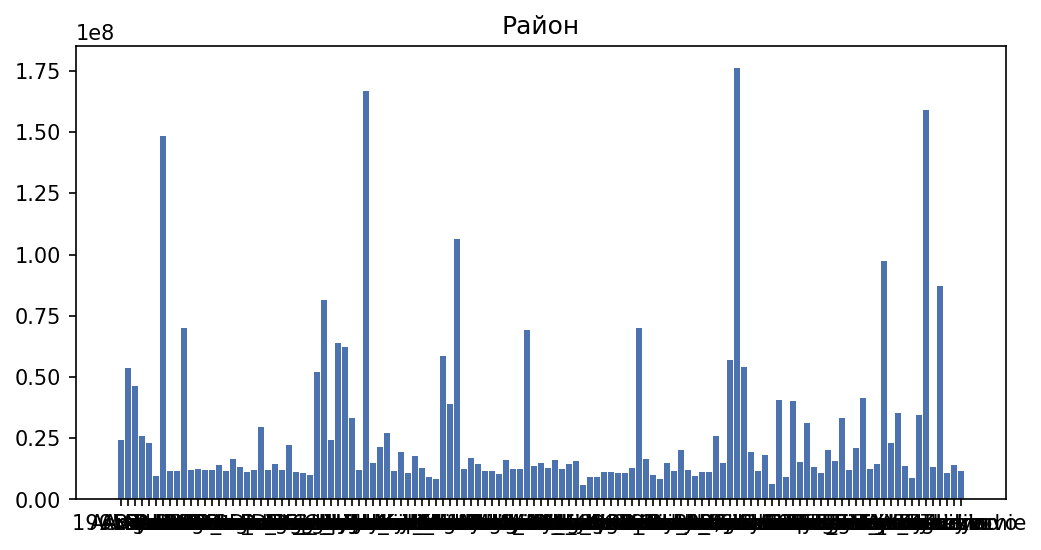

In [72]:
# Некрасивое cоотношение Район \ средняя цена
plt.figure(figsize=(8, 4))

n_bars = np.arange(len(msk_cor['Район'].unique())) 

grouped = pd.DataFrame(msk_cor.groupby(['Район'])['Цена'].mean().round())

plt.title('Район')
plt.bar(n_bars, grouped['Цена'])
plt.xticks(n_bars, grouped.index); 

### One Hot Encoding

In [73]:
cat_features = ['Метро', 
                'Парковка',  
                'Ремонт',
                #'Окна',
                #'Мусоропровод',
                #"Тип квартиры",
                "Тип дома",
                'Окружность', 
                'Количество комнат',
                'Округ',
                'Район'
               ]
features = ['Высота потолков, м',
            'Балкон',
            "Лоджия",
            'Лифт пасс',
            'Лифт груз',
            'Санузел совмещенный', 
            'Санузел раздельный', 
            'Площадь кв, м2', 
            "Этажность дома",
            "Этаж квартиры", 
            'Долгота',
            "Расстояние", 
            # 'Цена'
           ]
target = msk_cor[['Цена']]

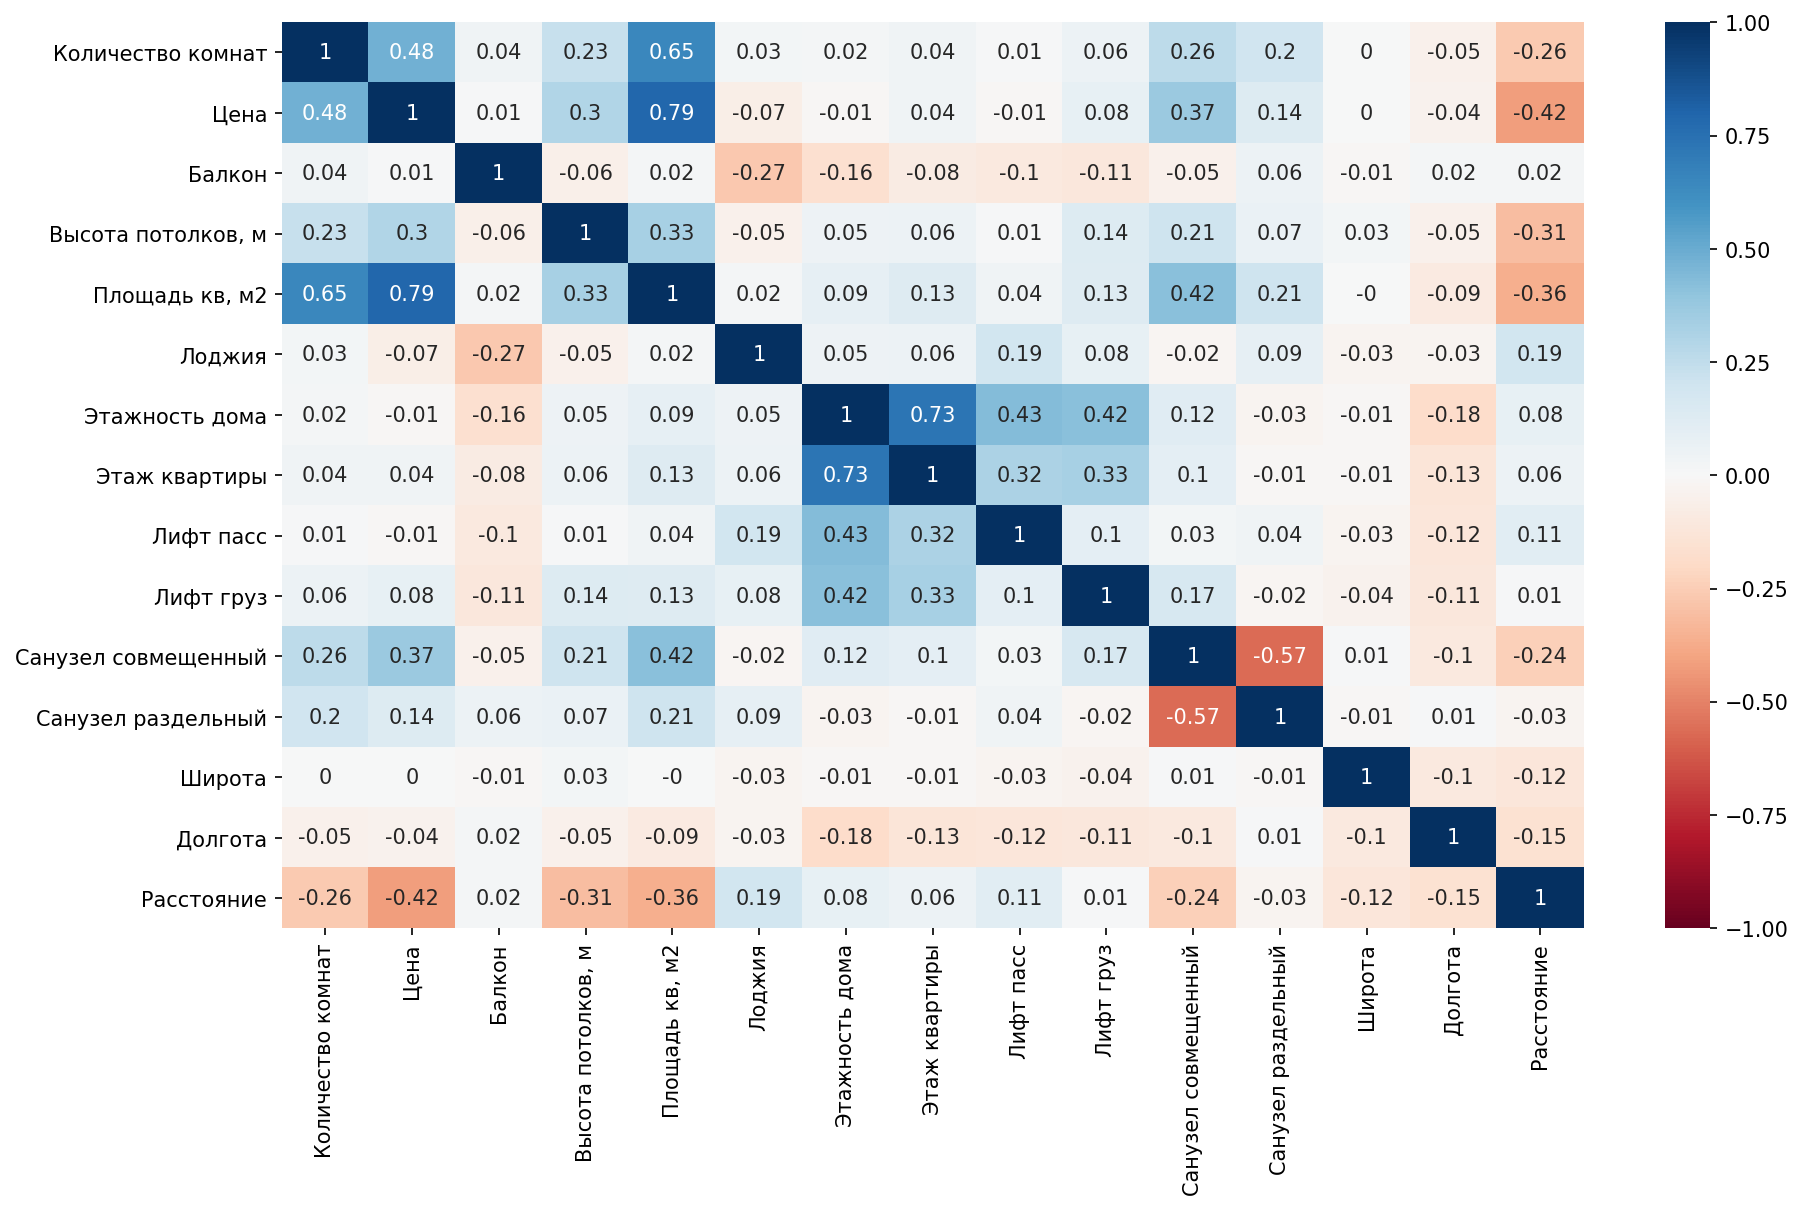

In [74]:
# Строим корреляционную матрицу по числовым фичам 
corr_matrix = msk_cor.corr().round(2)
figl, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corr_matrix, annot=True, cmap="RdBu", vmax=1, vmin=-1);

In [75]:
# *Для Backendа
# Создаём словари в которых каждое значение в столбике приравнивается к цифре
metro = {row: i for i, row in enumerate(sorted(list(set(msk_cor['Метро']))))}
parking = {row: i for i, row in enumerate(sorted(list(set(msk_cor['Парковка']))))}
repair = {row: i for i, row in enumerate(sorted(list(set(msk_cor['Ремонт']))))}
window = {row: i for i, row in enumerate(sorted(list(set(msk_cor['Окна']))))}
garbage_chute = {row: i for i, row in enumerate(sorted(list(set(msk_cor['Мусоропровод']))))}
house_type = {row: i for i, row in enumerate(sorted(list(set(msk_cor['Тип дома']))))}
circle = {row: i for i, row in enumerate(sorted(list(set(msk_cor['Окружность']))))}
district = {row: i for i, row in enumerate(sorted(list(set(msk_cor['Округ']))))}
neighborhood = {row: i for i, row in enumerate(sorted(list(set(msk_cor['Район']))))}
rooms = {row: i for i, row in enumerate(sorted(list(set(msk_cor['Количество комнат']))))}

# Меняем значения  столбиках на численные в правильном порядке по словарям
msk_cor['Метро'] = [metro[row] for row in msk_cor['Метро']]
msk_cor['Парковка'] = [parking[row] for row in msk_cor['Парковка']]
msk_cor['Ремонт'] = [repair[row] for row in msk_cor['Ремонт']]
msk_cor['Окна'] = [window[row] for row in msk_cor['Окна']]
msk_cor['Мусоропровод'] = [garbage_chute[row] for row in msk_cor['Мусоропровод']]
msk_cor['Тип дома'] = [house_type[row] for row in msk_cor['Тип дома']]
msk_cor['Окружность'] = [circle[row] for row in msk_cor['Окружность']]
msk_cor['Округ'] = [district[row] for row in msk_cor['Округ']]
msk_cor['Район'] = [neighborhood[row] for row in msk_cor['Район']]
msk_cor['Количество комнат'] = [rooms[row] for row in msk_cor['Количество комнат']]

In [76]:
# Encoding
for f in cat_features:
    msk_cor = pd.concat([msk_cor, pd.get_dummies(msk_cor[f], prefix = f)], axis = 1)
    features.extend([col for col in msk_cor if col.startswith(f + '_')])
features

['Высота потолков, м',
 'Балкон',
 'Лоджия',
 'Лифт пасс',
 'Лифт груз',
 'Санузел совмещенный',
 'Санузел раздельный',
 'Площадь кв, м2',
 'Этажность дома',
 'Этаж квартиры',
 'Долгота',
 'Расстояние',
 'Метро_0',
 'Метро_1',
 'Метро_2',
 'Метро_3',
 'Метро_4',
 'Метро_5',
 'Метро_6',
 'Метро_7',
 'Метро_8',
 'Метро_9',
 'Метро_10',
 'Метро_11',
 'Метро_12',
 'Метро_13',
 'Метро_14',
 'Метро_15',
 'Метро_16',
 'Метро_17',
 'Метро_18',
 'Метро_19',
 'Метро_20',
 'Метро_21',
 'Метро_22',
 'Метро_23',
 'Метро_24',
 'Метро_25',
 'Метро_26',
 'Метро_27',
 'Метро_28',
 'Метро_29',
 'Метро_30',
 'Метро_31',
 'Метро_32',
 'Метро_33',
 'Метро_34',
 'Метро_35',
 'Метро_36',
 'Метро_37',
 'Метро_38',
 'Метро_39',
 'Метро_40',
 'Метро_41',
 'Метро_42',
 'Метро_43',
 'Метро_44',
 'Метро_45',
 'Метро_46',
 'Метро_47',
 'Метро_48',
 'Метро_49',
 'Метро_50',
 'Метро_51',
 'Метро_52',
 'Метро_53',
 'Метро_54',
 'Метро_55',
 'Метро_56',
 'Метро_57',
 'Метро_58',
 'Метро_59',
 'Метро_60',
 'Метро_61',
 

In [77]:
# One Hot
for col in cat_features:
    if msk_cor[col].dtype == 'object':
        msk_cor[col] = pd.factorize(msk_cor[col])[0]

### Нормализация и деление на train/test

In [79]:
# Нормализация
scaler = StandardScaler()
normalised_msk_cor = scaler.fit_transform(msk_cor[features])

In [83]:
# train test split

x_train, x_test, y_train, y_test = train_test_split(normalised_msk_cor[:len(target)], target, test_size=0.025, random_state=1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39559, 460), (1015, 460), (39559, 1), (1015, 1))

# Обучаем модели

### XGBoost

#### XGBoost Cross-Validation

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [ ]:
cv_xgb_params = [
    (eta, gamma, max_depth, subsample, min_child_weight, colsample)
    for eta in [0.2, 0.3, 0.15]
    for gamma in [0, 0.3, 0.5]
    for max_depth in range(7,11)
    for subsample in [0.7, 0.75, 0.8]
    for min_child_weight in range(5, 10)
    for colsample in [i/10. for i in range(7,11)]
]
xgb_params = {}
num_boost_round = 999
xgb_params['eval_metric'] = 'mape'
min_mape = float("Inf")
min_rmse = float("Inf")

In [ ]:
xgb_params = {
    'booster': 'gbtree'
}
num_boost_round = 999
xgb_params['eval_metric'] = 'rmse'
min_mape = float("Inf")
min_rmse = float("Inf")
for eta, gamma, max_depth, subsample, min_child_weight, colsample in cv_xgb_params:
    print(f"eta={eta}, gamma={gamma}, max_depth={max_depth}, subsample={subsample}, min_child_weight={min_child_weight}, colsample={colsample}")
    xgb_params['eta'] = eta
    xgb_params['gamma'] = gamma
    xgb_params['max_depth'] = max_depth
    xgb_params['subsample'] = subsample
    xgb_params['min_child_weight'] = min_child_weight
#     xgb_params['colsample'] = colsample
    
    cv_results = xgb.cv(
    xgb_params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={"mae", "mape", "rmse"},
    early_stopping_rounds=25
    )
    
    mean_mape = cv_results['test-mape-mean'].min() * 100
    boost_mape_rounds = cv_results['test-mape-mean'].argmin()
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rmse_rounds = cv_results['test-rmse-mean'].argmin()
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    print("\tMAPE %{} for {} rounds".format(mean_mape, boost_mape_rounds))
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rmse_rounds))
    if mean_mape < min_mape and mean_rmse < min_rmse:
        min_mape = mean_mape
        min_rmse = mean_rmse
        best_params = (eta, gamma, max_depth, subsample, min_child_weight, colsample)

In [ ]:
best_params
cv_results


#### Fit - predict

In [ ]:
# Подбираем параметры модели - обучаем

xgb = XGBRegressor(
    booster ='dart',
    eta = 0.14186213775279433,
    gamma = 0.1,
    max_depth = 15,
    subsample = 0.99,
    colsample_bytree = 0.92,
    disable_default_eval_metric = True,
    min_child_weight = 4,
    normalize_type = 'forest',
    rate_drop = 0.2,
    eval_metric = 'mape'
)

xgb.fit(x_train, ravel(y_train))

In [ ]:
# Результаты 
print(f" RMSE is {sqrt(mean_squared_error(y_test, xgb.predict(x_test)))}")
print(f" MAPE is %{mean_absolute_percentage_error(y_test, xgb.predict(x_test))*100}")
print(f" SMAPE is {sMAPE(y_test.to_numpy(), xgb.predict(x_test))}")

In [ ]:
# Сохраняем модель
joblib.dump(xgb, 'xgb_mape_11.joblib')

['model1.joblib']

#### Функции метрик

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
def mae_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        sum_error += abs(predicted[i] - actual[i])
    return sum_error / float(len(actual))
def rmse_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        prediction_error = predicted[i] - actual[i]
        sum_error += (prediction_error ** 2)
    mean_error = sum_error / float(len(actual))
    return sqrt(mean_error)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Тестируем результат, сравниваем

In [ ]:
# Делаем предсказание, создаем новый датасет и анализируем полученный результат
xgb_results = xgb.predict(x_test)
submissions = msk_cor.index[:len(y_test)]
submissions = pd.DataFrame(submissions)
del submissions[0]
submissions['Предсказанная цена'] = xgb_results
empty_list = []
for row in submissions['Предсказанная цена']:
    empty_list.append(round(Decimal(row)))
submissions['Предсказанная цена'] = empty_list
submissions['Настоящая цена'] = y_test.reset_index(drop=True)
submissions['Отклонение'] = [submissions['Настоящая цена'][row] - submissions['Предсказанная цена'][row] for row in range(len(submissions))]
submissions.head(10)

,Предсказанная цена,Настоящая цена,Отклонение
10124,26915422,24500000,-2415422
10125,99896704,97771512,-2125192
10126,8708982,7500000,-1208982
10127,165895504,150000000,-15895504
10128,10326754,9900000,-426754
10129,154613664,160000000,5386336
10130,201664128,144000000,-57664128
10131,9521836,9000000,-521836
10132,127518848,138000000,10481152
10133,13593738,14500000,906262


In [ ]:
# Смотрим показатели метрик на тестовой выборке
print(mae_metric(submissions['Настоящая цена'], submissions['Предсказанная цена']))
print(rmse_metric(submissions['Настоящая цена'], submissions['Предсказанная цена']))
print(mean_absolute_percentage_error(submissions['Настоящая цена'], submissions['Предсказанная цена'])*100)